In [1]:
! pip install gym

Project Description:

Deterministic environmet:
Actions: 4 - left, right, top, bottom
States: 16 states (4*4 grid)
Rewards: 
Three positive rewards- Drinking Coffee-0.3, Studying-0.6, End Goal-1
Two Negative rewards- Bunk class- -0.5

Deterministic environmet:
Actions: 5 - left, right, top, bottom, stay in same position
States: 16 states (4*4 grid)
Rewards: 
Three positive rewards- Drinking Coffee-0.3, Studying-0.6, End Goal-1
Two Negative rewards- Bunk class- -0.5


In [660]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
from time import sleep
from scipy.stats import binom
from operator import add
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import random
import pandas as pd
from IPython.display import clear_output


# ---------------------------------Environment----------------------------------------

In [825]:
class GridEnvironment(gym.Env):
    
    def __init__(self):
        print("Intitializing the Env....")
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.positive_reward_1=[2,2]
        self.positive_reward_2=[1,1]
        self.negative_reward_1=[2,0]
        self.negative_reward_2=[0,2]
        
        self.state = np.zeros((4, 4))
        observation = self.state.flatten()
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 100     
        self.qtable=np.zeros((self.observation_space.n,self.action_space.n))
        
        values=[i for i in range(16)]
        keys=[]
        for i in range(4):
            for j in range(4):
                keys.append((i,j))
        self.mapping=dict(zip(keys,values))
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.positive_reward_1=[2,2]
        self.positive_reward_2=[1,1]
        self.negative_reward_1=[2,0]
        self.negative_reward_2=[0,2]
        self.state = np.zeros((4, 4)) 
#         self.qtable=np.zeros((self.observation_space.n,self.action_space.n))
        observation = self.state.flatten()
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 100
        values=[i for i in range(16)]
        keys=[]
        for i in range(4):
            for j in range(4):
                keys.append((i,j))
        self.mapping=dict(zip(keys,values))
        
        return observation
    
    def step(self,env_type,action):
        if(env_type=='D'):
            if action == 0:
                self.agent_pos[0] += 1
            if action == 1:
                self.agent_pos[0] -= 1
            if action == 2:
                self.agent_pos[1] += 1
            if action == 3:
                self.agent_pos[1] -= 1
        else:
            #random value here is either 0 or 1 - Agent Stays in same state with 40% probabilty
            random_value=self.get_random_value_by_probability()
            if action == 0:
                self.agent_pos[0] += random_value
            if action == 1:
                self.agent_pos[0] -= random_value
            if action == 2:
                self.agent_pos[1] += random_value
            if action == 3:
                self.agent_pos[1] -= random_value
                
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        
        info = {}        
        observation = self.state.flatten()
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
            reward = 10
            done=True
            new_agent_pos=self.mapping[tuple(self.agent_pos)]
            return new_agent_pos, reward, done, info
        elif (self.agent_pos == self.positive_reward_1).all():
            reward=6
        elif (self.agent_pos == self.positive_reward_2).all():
            reward=3
        elif(self.agent_pos == self.negative_reward_1).all():
            reward= -5
        elif(self.agent_pos == self.negative_reward_2).all():
            reward= -6
            
        self.timestep += 1
        done = True if self.timestep >= self.max_timesteps else False
        
        new_agent_pos=self.mapping[tuple(self.agent_pos)]
        return new_agent_pos, reward, done, info
    
    def get_random_value_by_probability(self):
        x=np.random.randint(0, 10)
        random_value=0
        if x <= 6:
            random_value=1
        return random_value
        
    def render(self,mode='human',plot=False):
        fig,ax=plt.subplots(figsize=(10,10))
        ax.set_xlim(0,4)
        ax.set_ylim(0,4)
                
        agent = AnnotationBbox(OffsetImage(plt.imread('./images/robot/Robot_pos1.png'), zoom=0.4),  # Plotting the agent.
                           list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
        ax.add_artist(agent)

        if (self.agent_pos == self.goal_pos):
            goal = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/grad.png'), zoom=0.12),  # Plotting the agent.
                           list(map(add, self.goal_pos, [0.5, 0.5])), frameon=False)
            agent.remove()
        else:
            goal = AnnotationBbox(OffsetImage(plt.imread('./images/RL-696x309.png'), zoom=0.2),  # Plotting the agent.
                           list(map(add, self.goal_pos, [0.5, 0.5])), frameon=False)
        ax.add_artist(goal)
        
        if(self.agent_pos == self.negative_reward_1):
            negative_rw_1 = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/Conf_bunk.png'), zoom=0.11),  # Plotting the agent.
                           list(map(add, self.negative_reward_1, [0.5, 0.5])), frameon=False)
            agent.remove()
        else:
            negative_rw_1 = AnnotationBbox(OffsetImage(plt.imread('./images/bunk.jpeg'), zoom=0.4),  # Plotting the agent.
                           list(map(add, self.negative_reward_1, [0.5, 0.5])), frameon=False)
        ax.add_artist(negative_rw_1)
        
        if(self.agent_pos == self.negative_reward_2):
            negative_rw_2 = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/Conf_bunk.png'), zoom=0.11),  # Plotting the agent.
                           list(map(add, self.negative_reward_2, [0.5, 0.5])), frameon=False)
            agent.remove()
        else:
            negative_rw_2 = AnnotationBbox(OffsetImage(plt.imread('./images/bunk.jpeg'), zoom=0.4),  # Plotting the agent.
                           list(map(add, self.negative_reward_2, [0.5, 0.5])), frameon=False)
        ax.add_artist(negative_rw_2)
        
        if(self.agent_pos == self.positive_reward_1):
            positive_rw_1 = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/assignment.png'), zoom=0.21),  # Plotting the agent.
                           list(map(add, self.positive_reward_1, [0.5, 0.5])), frameon=False)
            agent.remove()
        else:
            positive_rw_1 = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/books.png'), zoom=0.15),  # Plotting the agent.
                           list(map(add, self.positive_reward_1, [0.5, 0.5])), frameon=False)
        ax.add_artist(positive_rw_1)
        
        if(self.agent_pos == self.positive_reward_2):
            positive_rw_2 = AnnotationBbox(OffsetImage(plt.imread('./images/robot1/robot_coffee_final.png'), zoom=0.25),  # Plotting the agent.
                           list(map(add, self.positive_reward_2, [0.5, 0.5])), frameon=False)
            agent.remove()
        else:
            positive_rw_2 = AnnotationBbox(OffsetImage(plt.imread('./images/coffee.png'), zoom=0.15),  # Plotting the agent.
                           list(map(add, self.positive_reward_2, [0.5, 0.5])), frameon=False)
        ax.add_artist(positive_rw_2)
        
        ax.set_xticks(np.arange(0, 4, 1))
        ax.set_yticks(np.arange(0, 4, 1))
        plt.grid(fig, linewidth=1,which='both', axis='both')


# ------------------------Training and Testing the models------------------------

In [826]:
class TrainAndTestModels():
    def __init__(self):
        #Initializing Training and Debug Params 
        self.reward_per_episode_array=[]
        self.qtables_array=[]
        self.rewards_in_episode_for_optimal_policy=[]
        self.winning_state=[]
        self.episilon_decay_array=[]
        
        #Instantiate logs
        self.logs=dict(qtable=np.zeros((16,4)), reward_per_episode=[], episilon_decay=[],env_type='',model='',env='')
    
    def train(self,model_type,env_type,alpha,gamma,num_of_episodes):
        #Initialize the environment
        env = GridEnvironment()
        if(model_type=='QL'):
            qtable_Q_learning=self.trainQL(env_type,env,alpha,gamma,num_of_episodes)
        elif(model_type=='SARSA'):
            qtable_Q_learning=self.trainSARSA(env_type,env,alpha,gamma,num_of_episodes)

    def trainQL(self,env_type,env,alpha,gamma,num_of_episodes):
        print("<-------------------Q-Learning-------------------->")
        if(env_type=='D'):
            print("<-------------------Training QL Deterministic Environment-------------------->")
        elif(env_type=='S'):
            print("<-------------------Training QL Stochastic Environment-------------------->")
        
        for episode in range(num_of_episodes):
            
            epsilon = 1
            max_epsilon = 1
            min_epsilon = 0.01
            epsilon_decay_rate = 0.01
        
            env.reset()
            
            cum_reward_per_episode=0
            actions_in_one_episode=[]
            states_passed_in_one_episode=[]
            rewards_in_episode=[]
            states_passed_in_one_episode.append(env.mapping[tuple(env.agent_pos)])
            greedy_a=0
            random_a=1
            
            while True:
                state=env.mapping[tuple(env.agent_pos)]
                qtable_state=env.qtable[state]
                greedy_action=np.argmax(qtable_state)
                greedy_q_value= max(qtable_state)
        
                #Select Greedy or Random Action
                epsilon_rate_threshold=random.uniform(0,1)
                if epsilon_rate_threshold> epsilon:
                    action=greedy_action
                    greedy_a=greedy_a+1
                else:
                    action=env.action_space.sample()
                    random_a=random_a+1
                self.episilon_decay_array.append(epsilon)
                
                #Step Function
                new_observation, reward, done, _ = env.step('D',action)
                
                if(new_observation in states_passed_in_one_episode):
                    reward= -1            
                if(new_observation==state):
                    reward= -10
            
                #Q-Learning Qtable formation
                qtable_state[action]=qtable_state[action]+(alpha*(reward+gamma*max(env.qtable[new_observation])-qtable_state[[action]]))
            
                env.qtable[state]=qtable_state
            
                actions_in_one_episode.append(action)
                states_passed_in_one_episode.append(new_observation)
                cum_reward_per_episode=cum_reward_per_episode+reward
                rewards_in_episode.append(reward)
                
                #Epsilon Decay (Exponential decay is used here)
                epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate*episode)
            
                if done==True:
                    self.reward_per_episode_array.append(cum_reward_per_episode)
                    self.qtables_array.append(env.qtable)
                    if(cum_reward_per_episode >= max(self.reward_per_episode_array)):
                        self.winning_state=states_passed_in_one_episode
                        self.rewards_in_episode_for_optimal_policy=rewards_in_episode
                    break
                    
        print("Final Q Table",env.qtable)
        
        #Logging....
        self.logs['qtable']=env.qtable
        self.logs['env_type']=env_type
        self.logs['reward_per_episode']=self.reward_per_episode_array
        self.logs['episilon_decay']=self.episilon_decay_array
        self.logs['env']=env
        self.logs['model']='Q-Learning'
        
    def trainSARSA(self,env_type,env,alpha,gamma,num_of_episodes):
        print("<-------------------SARSA-------------------->")
        if(env_type=='D'):
            print("<-------------------Training SARSA Deterministic Environment-------------------->")
        elif(env_type=='S'):
            print("<-------------------Training SARSA Stochastic Environment-------------------->")
        
        for episode in range(num_of_episodes):
    
            epsilon = 1
            max_epsilon = 1
            min_epsilon = 0.01
            epsilon_decay_rate = 0.01
        
            #Second epsilon function for A'
            epsilon2=0.9
            max_epsilon2 = 1
            min_epsilon2 = 0.03
            epsilon_decay_rate2 = 0.03
            
            env.reset()
            
            cum_reward_per_episode=0
            actions_in_one_episode=[]
            states_passed_in_one_episode=[]
            rewards_in_episode=[]
            states_passed_in_one_episode.append(env.mapping[tuple(env.agent_pos)])
            greedy_a=0
            random_a=1
            
            while True:
                state=env.mapping[tuple(env.agent_pos)]
                qtable_state=env.qtable[state]
                greedy_action=np.argmax(qtable_state)
                greedy_q_value= max(qtable_state)
        
                #Selecting Random v/s Greedy action
                epsilon_rate_threshold=random.uniform(0,1)
                if epsilon_rate_threshold> epsilon:
                    action=greedy_action
                    greedy_a=greedy_a+1
                else:
                    action=env.action_space.sample()
                    random_a=random_a+1
                self.episilon_decay_array.append(epsilon)
            
                new_observation, reward, done, _ = env.step('D',action)
                        
                if(new_observation in states_passed_in_one_episode):
                    reward= -1            
                if(new_observation==state):
                    reward= -10
           
            
                #Selecting A' 
                epsilon_rate_threshold=random.uniform(0,1)
                if epsilon_rate_threshold> epsilon2:
                    new_action=greedy_action
                else:
                    new_action=env.action_space.sample()
                
                #Calculate QTable for SARSA
                qtable_state[action]=qtable_state[action]+(alpha*(reward+gamma*(env.qtable[new_observation][new_action])-qtable_state[[action]]))
            
                #Decaying the Epsilon functions 
                epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate*episode)
                epsilon2 = min_epsilon2 + (max_epsilon2 - min_epsilon2) * np.exp(-epsilon_decay_rate2*episode)

                env.qtable[state]=qtable_state
            
                actions_in_one_episode.append(action)
                states_passed_in_one_episode.append(new_observation)
                cum_reward_per_episode=cum_reward_per_episode+reward
                rewards_in_episode.append(reward)
                        
                if done==True:
                    self.reward_per_episode_array.append(cum_reward_per_episode)
                    self.qtables_array.append(env.qtable)
                    if(cum_reward_per_episode >= max(self.reward_per_episode_array)):
                        self.winning_state=states_passed_in_one_episode
                        self.rewards_in_episode_for_optimal_policy=rewards_in_episode
                    break
                    
        print("FINAL Q TABLE: ",env.qtable)
        
        #Logging.....
        self.logs['qtable']=env.qtable
        self.logs['env_type']=env_type
        self.logs['reward_per_episode']=self.reward_per_episode_array
        self.logs['episilon_decay']=self.episilon_decay_array
        self.logs['env']=env
        self.logs['model']='SARSA'

    def testModels(self,qtable,env_type,ip_env):
        ip_env.reset()
        print("Using Q table to move though the optimal states......")
        state=ip_env.mapping[(0,0)]
        inv_map = {v: k for k, v in ip_env.mapping.items()}
        while True:
            qtable_state=ip_env.qtable[state]
            optimal_action=np.argmax(qtable_state)
            new_observation, reward, done, _ = ip_env.step(env_type,optimal_action)
            state=new_observation
            ip_env.agent_pos=list(inv_map.get(state))
            ip_env.render()
            sleep(.1)
            if(done):
                break

## -------------------------------------------Q-Learning-----------------------------------------------

## Train Q-Learning Deterministic Model

In [827]:
#learning rate
alpha=0.4
#discount rate
gamma=0.7
#num_of_episodes
num_of_episodes=200

ttm=TrainAndTestModels()
ttm.train('QL','D',alpha,gamma,num_of_episodes)

Intitializing the Env....
<-------------------Q-Learning-------------------->
<-------------------Training QL Deterministic Environment-------------------->
Final Q Table [[ 5.03411179 -6.24743271  5.65159618 -6.63155741]
 [ 8.31926448 -5.01890553 -1.1855341   2.72283658]
 [ 6.69283602 -7.50993192  2.01061727  1.97773536]
 [ 4.08785491 -9.57336259 -8.8815498  -2.43879383]
 [-0.91262162  2.52140585  7.5371328  -5.31723466]
 [ 7.60636445  4.48150774  5.29561279  4.96381915]
 [ 6.95906959 -0.7846198   4.33030367  3.83073098]
 [ 6.50089079  0.75235456 -5.99776041  3.87502893]
 [ 2.28754866  2.68799518  6.43067283 -6.36399758]
 [ 4.39892578  3.98030654 10.87490733 -0.74189569]
 [ 6.59999998  6.07237725  6.98924727  6.5407661 ]
 [10.          4.42873009 -3.00385365  5.64038137]
 [-7.54905448  1.68517896  4.14972928 -7.4925716 ]
 [-5.49596376  5.68773722  6.6311296   1.94441419]
 [-3.00000001  4.07858198 10.          4.11537558]
 [ 0.          0.          0.          0.        ]]


### Reward per episode graph for Q-Learning Deterministic Environment

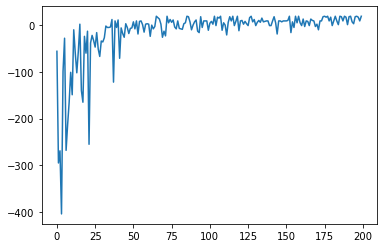

In [828]:
plt.plot(ttm.logs['reward_per_episode'])

### Epison Decay graph for Q-Learning Deterministic Environment

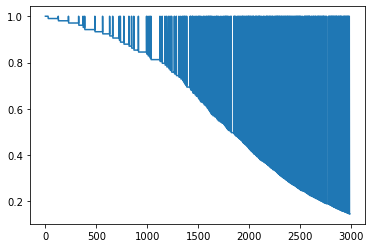

In [829]:
plt.plot(ttm.logs['episilon_decay'])

## ------------------------ Test Q-Learning Deterministic Environment Optimal Policy----------

Model:  Q-Learning Environment type:  D
Using Q table to move though the optimal states......


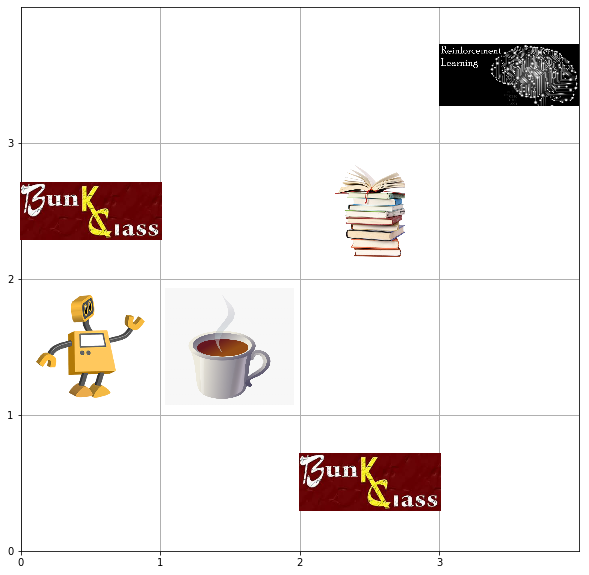

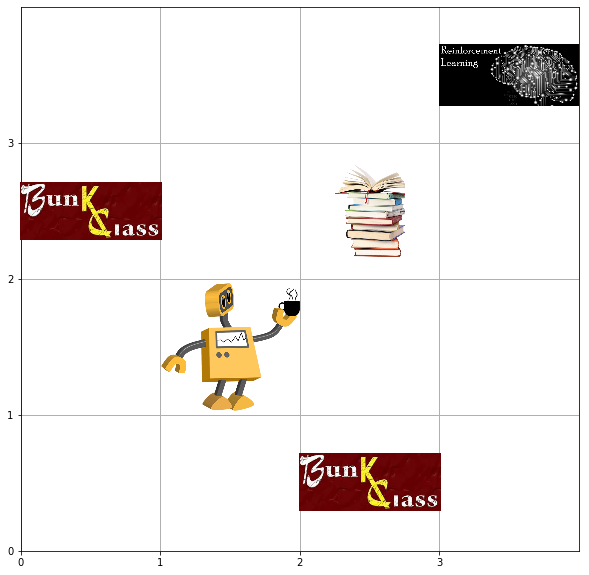

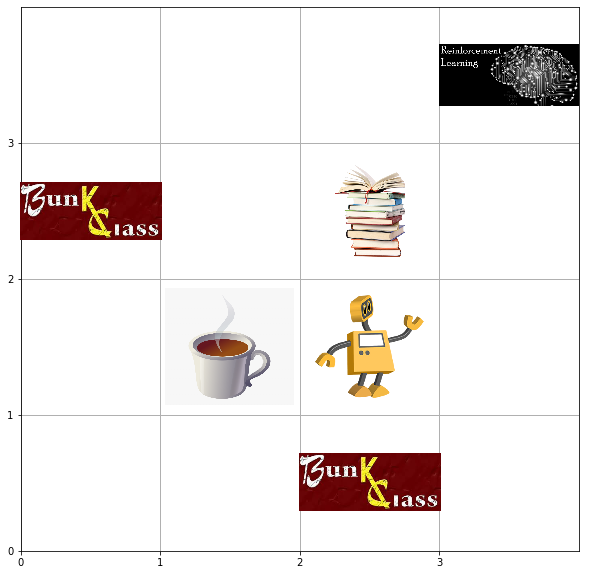

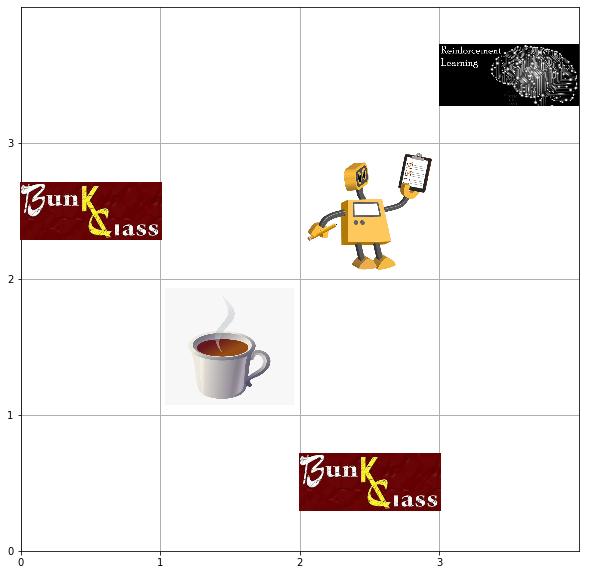

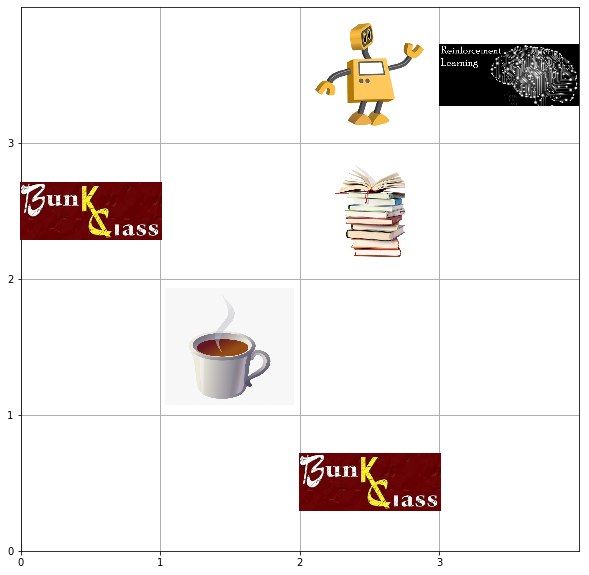

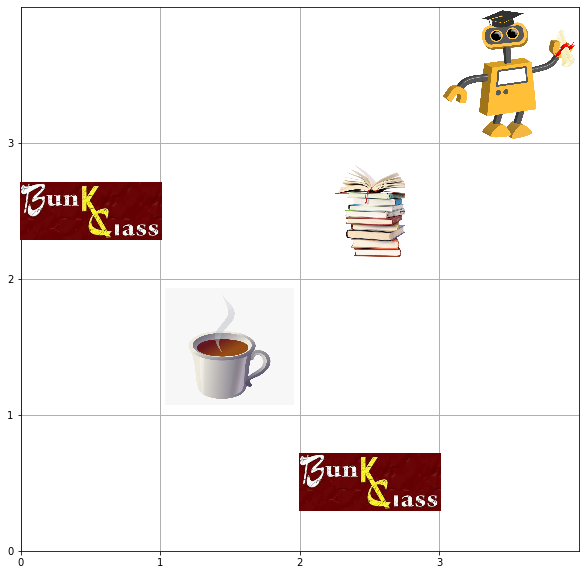

In [830]:
print("Model: ",ttm.logs['model'],"Environment type: ",ttm.logs['env_type'])
ttm.testModels(ttm.logs['qtable'],ttm.logs['env_type'],ttm.logs['env'])

## -------------------------------Train Q-Learning Stochastic Model--------------------------------

In [845]:
#learning rate
alpha=0.4
#discount rate
gamma=0.7
#num_of_episodes
num_of_episodes=200

ttm=TrainAndTestModels()
ttm.train('QL','S',alpha,gamma,num_of_episodes)

Intitializing the Env....
<-------------------Q-Learning-------------------->
<-------------------Training QL Stochastic Environment-------------------->
Final Q Table [[ 5.83297946 -5.9615733   5.55349203 -5.95078009]
 [ 8.2634657  -4.63982141 -3.65199978  2.90893446]
 [ 2.30275709 -8.38715019  2.3641171   4.23804988]
 [ 4.05210744 -7.37610533 -7.29754081 -0.29317299]
 [-0.26442032  2.31900709  8.3393945  -5.02800312]
 [ 7.62995938  4.55168979  5.38785067  4.41760537]
 [ 5.38484657 -1.57812915  4.54324207  3.63105175]
 [ 6.07733035  2.29910696 -5.51331231  2.69351513]
 [ 2.12007162  2.94068901  7.02516071 -6.87632783]
 [ 4.56077987  4.13979127 10.9        -0.06880399]
 [ 6.67358531  5.14944053  7.          5.86178553]
 [10.          4.32276763 -3.00005166  4.09637069]
 [-8.54218556 -0.50400433  4.28058509 -8.64408668]
 [-5.89503552  5.84610069  6.50238441 -0.0637669 ]
 [-3.00492991  4.13503283 10.          4.39309007]
 [ 0.          0.          0.          0.        ]]


### Reward per episode graph for Q-Learning Stochastic Environment

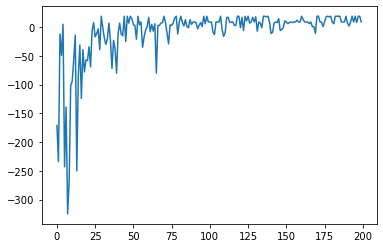

In [846]:
plt.plot(ttm.logs['reward_per_episode'])

### Epison Decay graph for Q-Learning Stochastic Environment

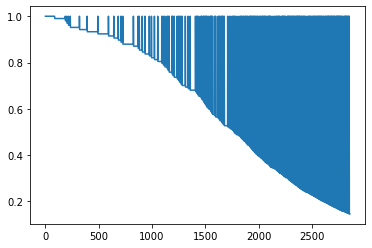

In [847]:
plt.plot(ttm.logs['episilon_decay'])

## -------------------Test Q-Learning Stochastic Environment Optimal Policy-------------------

Model:  Q-Learning Environment type:  S
Using Q table to move though the optimal states......


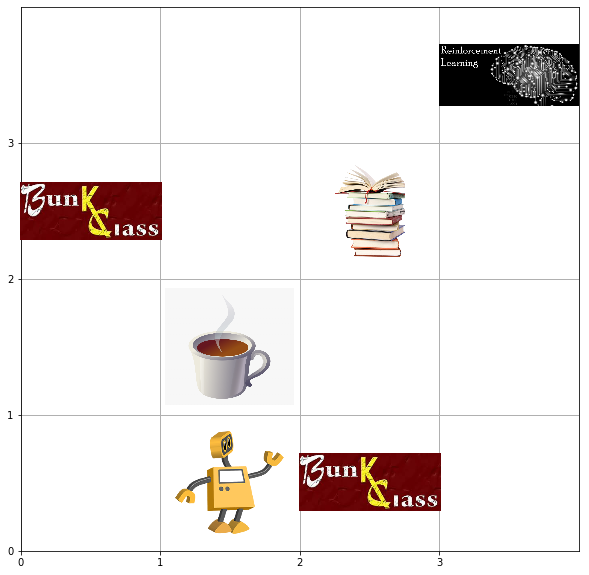

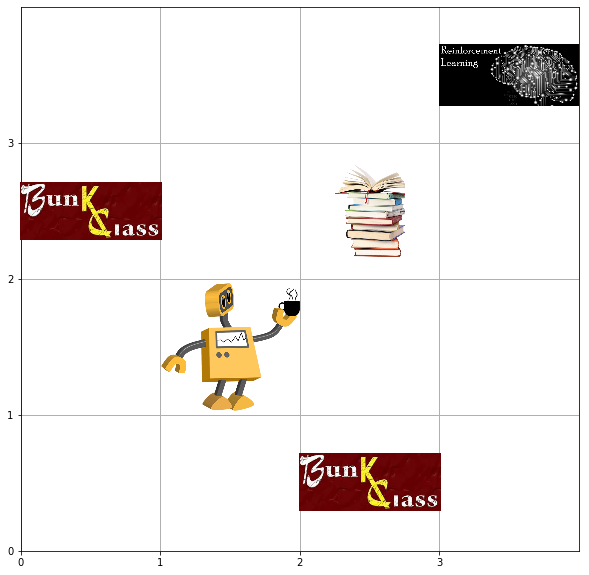

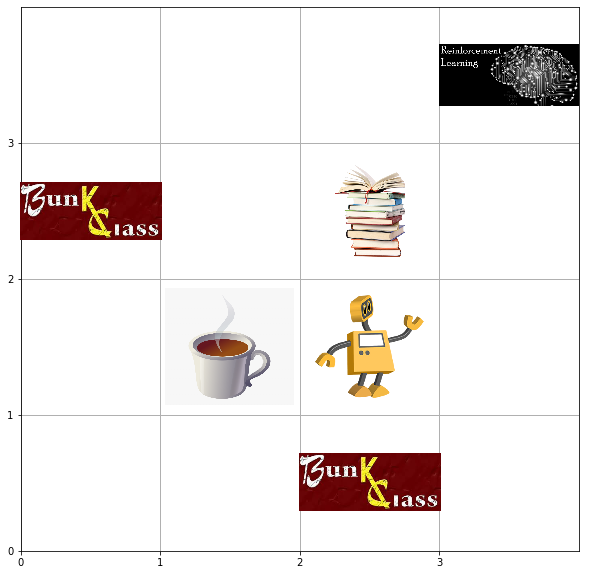

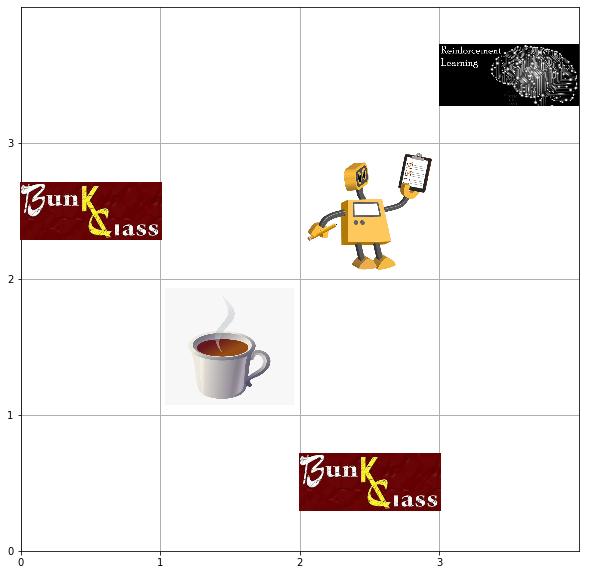

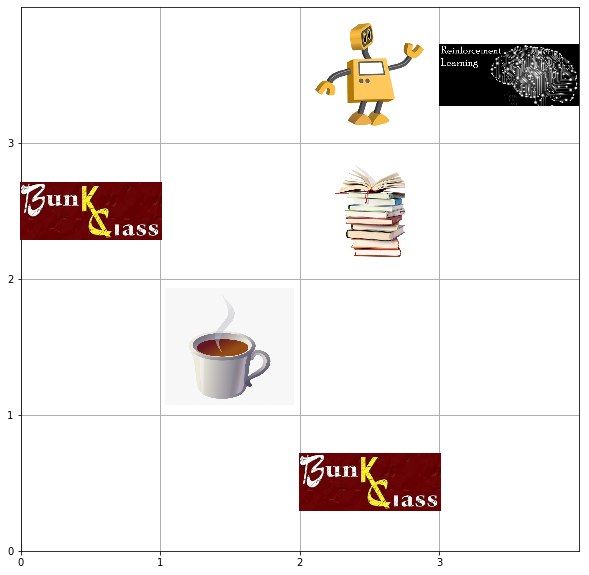

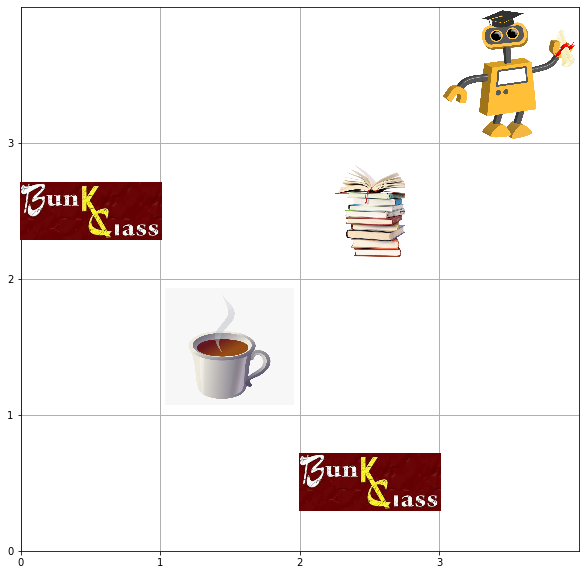

In [848]:
print("Model: ",ttm.logs['model'],"Environment type: ",ttm.logs['env_type'])
ttm.testModels(ttm.logs['qtable'],ttm.logs['env_type'],ttm.logs['env'])

# ----------------------------------SARSA----------------------------------------- 

## ---------------------Train SARSA Deterministic Model--------------------------

In [849]:
#learning rate
alpha=0.4
#discount rate
gamma=0.7
#num_of_episodes
num_of_episodes=200

ttm=TrainAndTestModels()
ttm.train('SARSA','D',alpha,gamma,num_of_episodes)

Intitializing the Env....
<-------------------SARSA-------------------->
<-------------------Training SARSA Deterministic Environment-------------------->
FINAL Q TABLE:  [[ -3.69516433 -18.05230412  -4.9351608  -14.34077617]
 [  2.4235261   -8.32152132  -7.51462748  -3.35676188]
 [  0.19644411 -11.92362736  -6.56562531  -5.12547707]
 [  2.99901827 -13.42589911 -19.22470633  -4.98083008]
 [ -3.84062653  -2.61787105   1.39288169  -9.54693058]
 [ -0.48955029  -4.30035627  -0.62892234  -3.84523282]
 [ -2.25527781  -4.66744032  -3.12791548  -2.76952014]
 [  6.70708891  -0.73337195  -7.2907874   -1.12231113]
 [ -1.38697423  -1.60352044   2.6339164  -11.15290057]
 [ -0.88510815  -1.50040775   0.55507055  -3.58111975]
 [  1.44067547  -2.83756467  -1.77297109  -2.45410132]
 [ 10.           3.50275988  -3.05453836  -1.75294927]
 [ -8.99106174  -3.31082753   4.09131137  -8.34627106]
 [ -6.56359982  -1.22586714   6.9208201   -1.42904785]
 [ -3.52051154  -1.49144659  10.           4.12857241]
 [  

### Reward per episode graph for SARSA Deterministic Environment

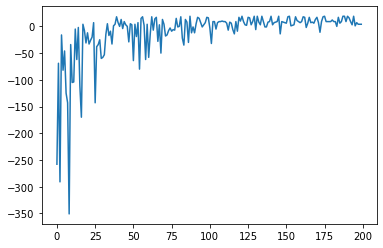

In [850]:
plt.plot(ttm.logs['reward_per_episode'])

### Epison Decay graph for SARSA Deterministic Environment

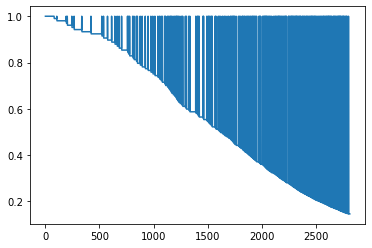

In [851]:
plt.plot(ttm.logs['episilon_decay'])

## ---------------------- Test SARSA Deterministic Environment Optimal Policy-----------------

Model:  SARSA Environment type:  D
Using Q table to move though the optimal states......


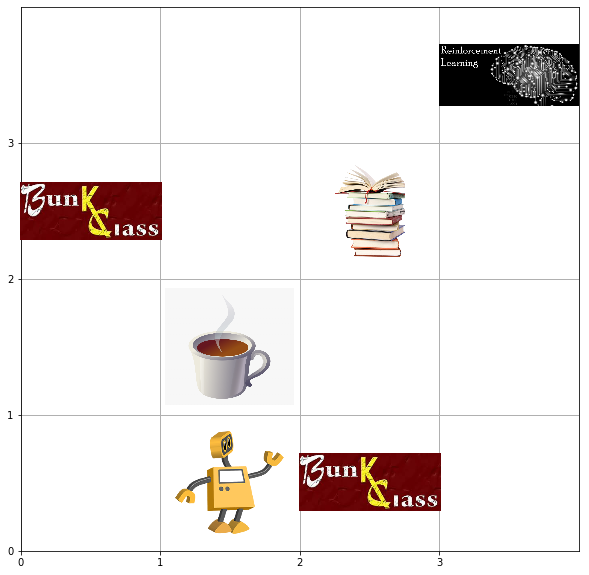

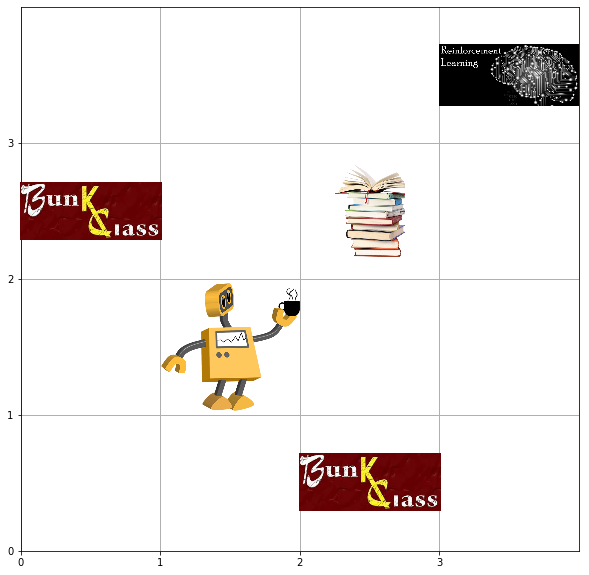

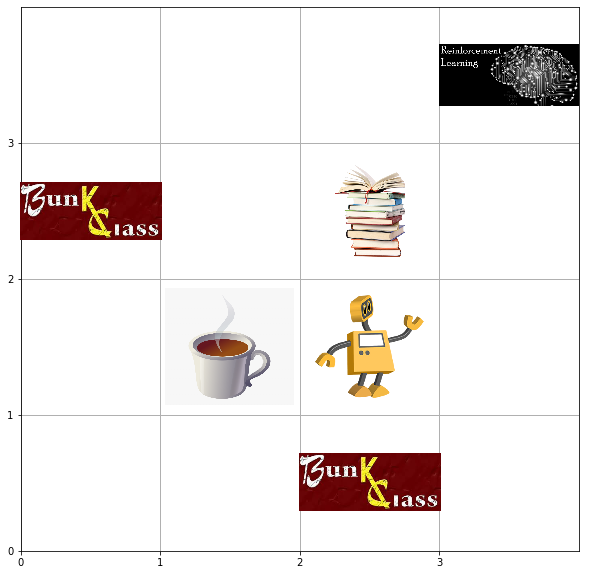

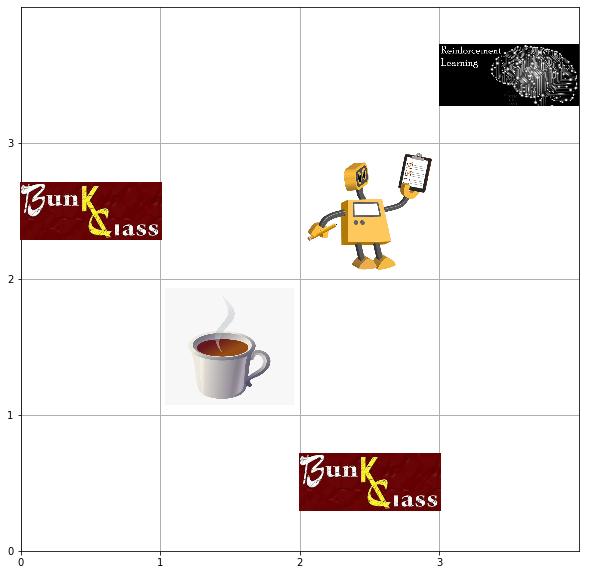

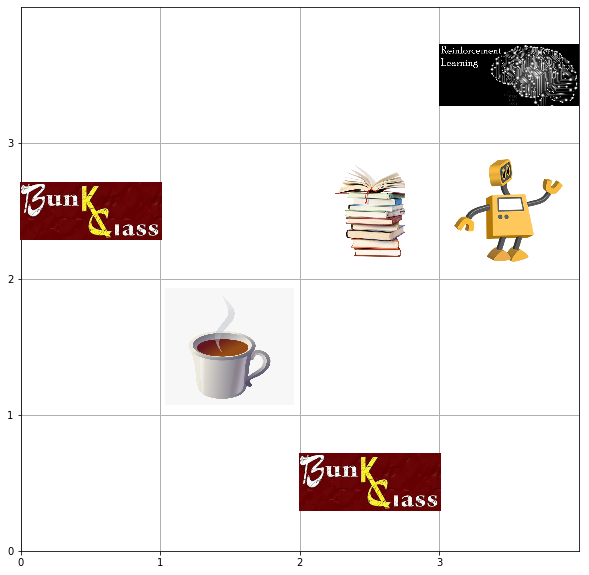

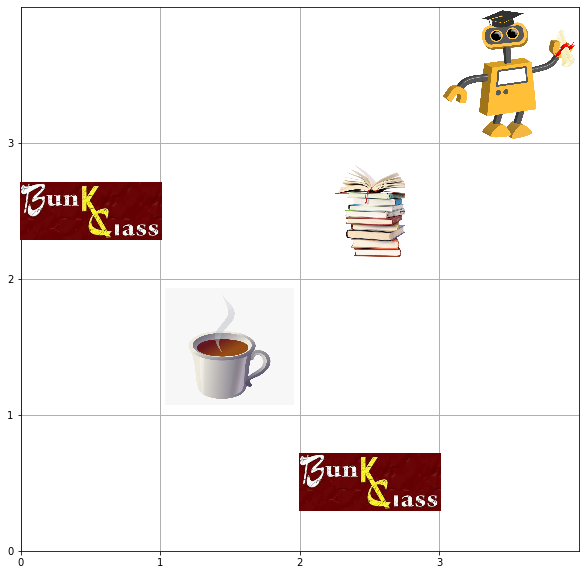

In [852]:
print("Model: ",ttm.logs['model'],"Environment type: ",ttm.logs['env_type'])
ttm.testModels(ttm.logs['qtable'],ttm.logs['env_type'],ttm.logs['env'])

## --------------------------------Train SARSA Stochastic Model-----------------------------------

In [853]:
#learning rate
alpha=0.4
#discount rate
gamma=0.7
#num_of_episodes
num_of_episodes=200

ttm=TrainAndTestModels()
ttm.train('SARSA','S',alpha,gamma,num_of_episodes)

Intitializing the Env....
<-------------------SARSA-------------------->
<-------------------Training SARSA Stochastic Environment-------------------->
FINAL Q TABLE:  [[-1.47619131e+00 -1.94039981e+01 -3.59230952e+00 -1.39900291e+01]
 [ 3.12016525e+00 -9.14783268e+00 -6.86758349e+00 -3.05142908e+00]
 [ 1.96272523e+00 -1.06708117e+01 -4.09207027e+00 -4.74689278e-01]
 [ 9.13383367e-03 -1.29397222e+01 -1.17497052e+01 -2.82184015e+00]
 [-3.88067522e+00 -3.43560744e+00  1.25694257e+00 -8.10435055e+00]
 [ 2.40548777e+00 -3.55945037e-01 -1.16151887e+00 -2.38381835e+00]
 [-1.89027238e+00 -3.55584323e+00 -1.48849124e+00 -1.69599007e+00]
 [ 6.64718214e+00 -3.28097586e+00 -1.05561944e+01  1.04764543e+00]
 [ 7.58873646e-02 -2.71821385e+00  2.40271589e+00 -9.40311611e+00]
 [ 3.46298223e+00 -1.85863814e+00  4.49115248e+00 -3.56417350e+00]
 [-2.10063825e+00 -2.70949921e+00 -2.15652083e+00 -2.31750671e+00]
 [ 1.00000000e+01  3.92617518e+00 -3.30502776e+00 -1.85510752e+00]
 [-1.48270012e+01 -3.5954961

### Reward per episode graph for SARSA Stochastic Environment

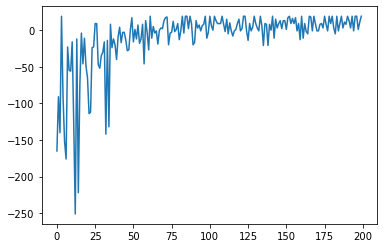

In [854]:
plt.plot(ttm.logs['reward_per_episode'])

### Epison Decay graph for SARSA Stochastic Environment

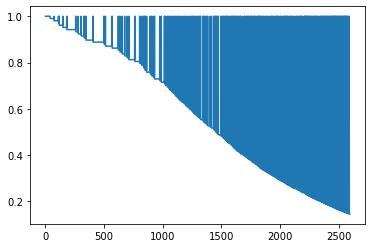

In [855]:
plt.plot(ttm.logs['episilon_decay'])

## -------------------------Test SARSA Stochastic Environment Optimal Policy------------------

Model:  SARSA Environment type:  S
Using Q table to move though the optimal states......


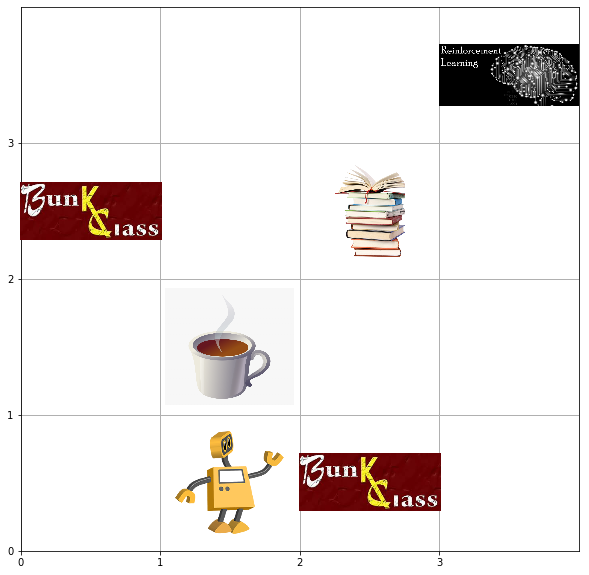

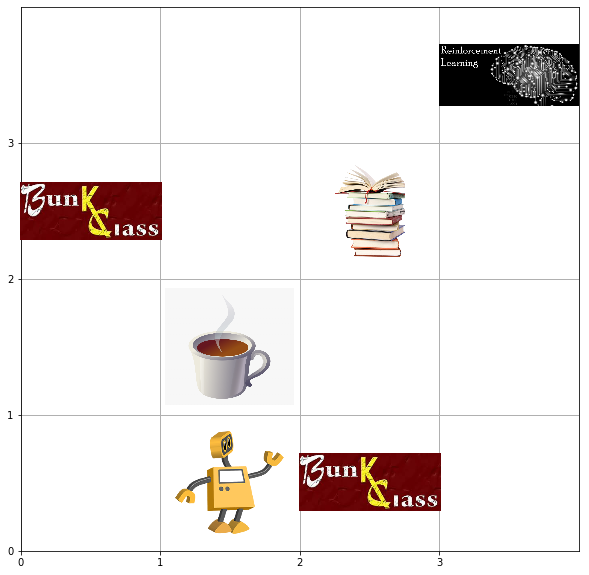

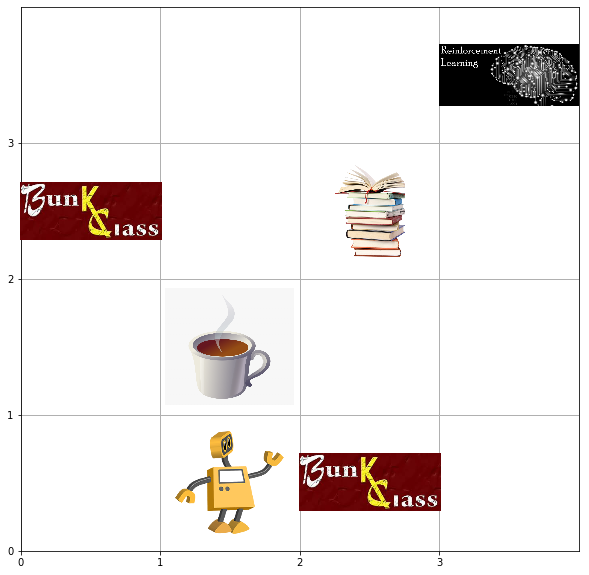

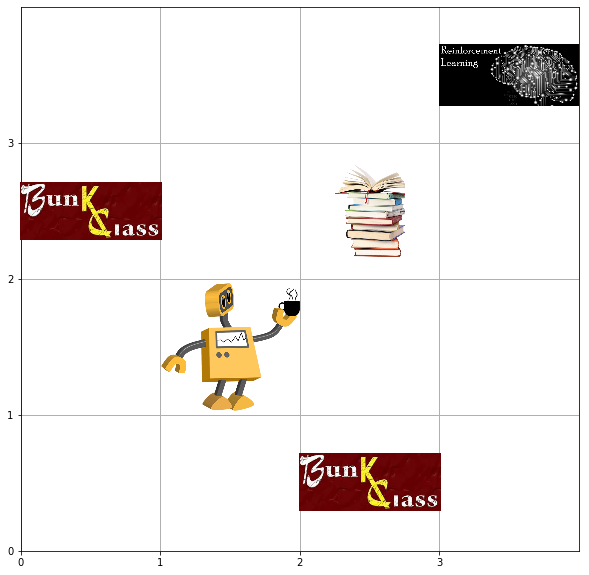

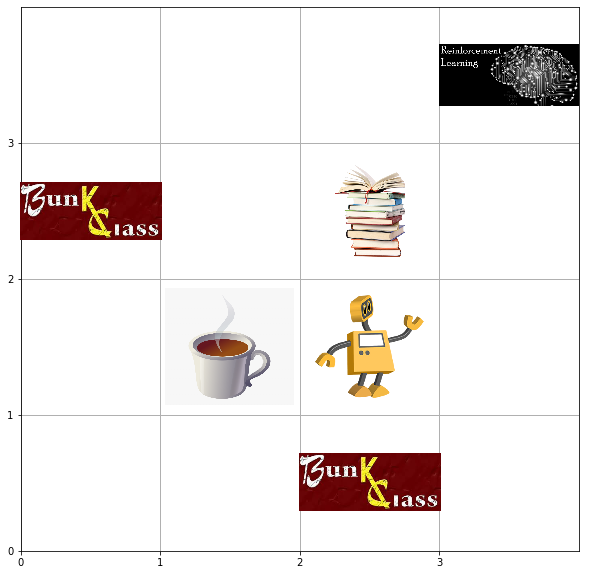

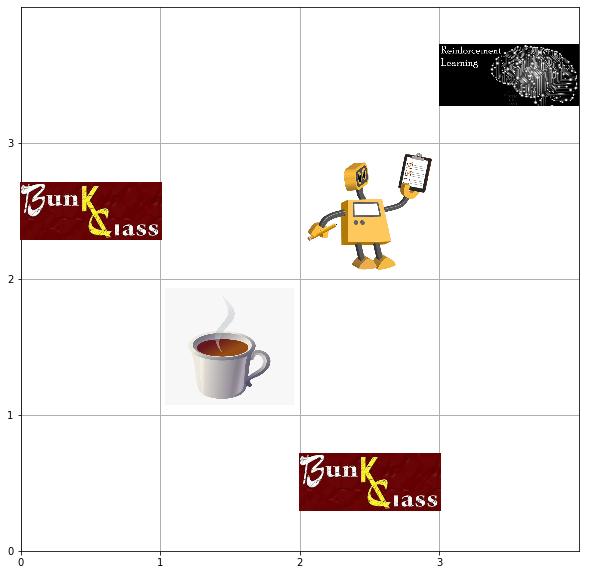

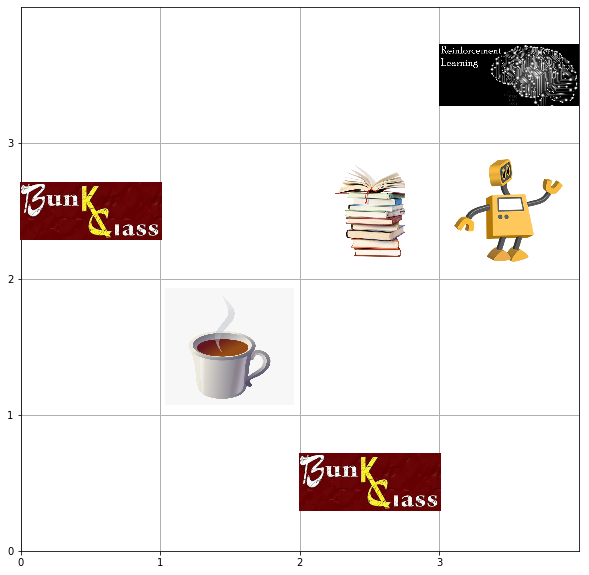

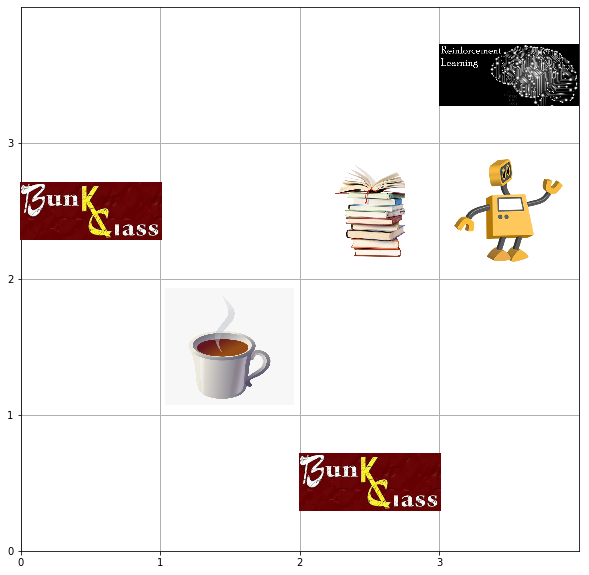

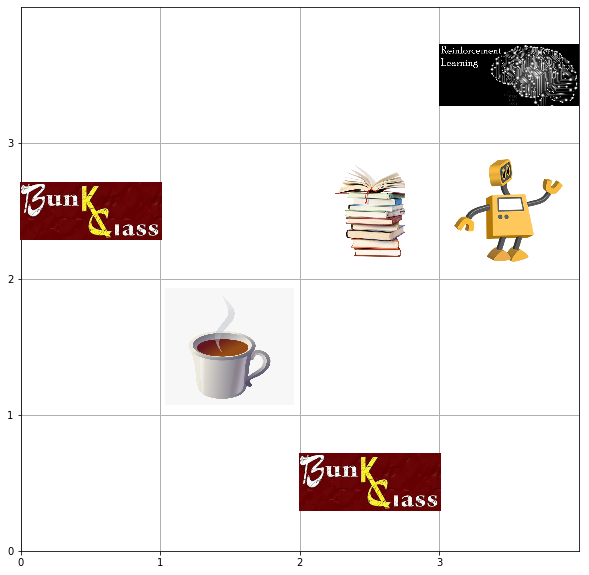

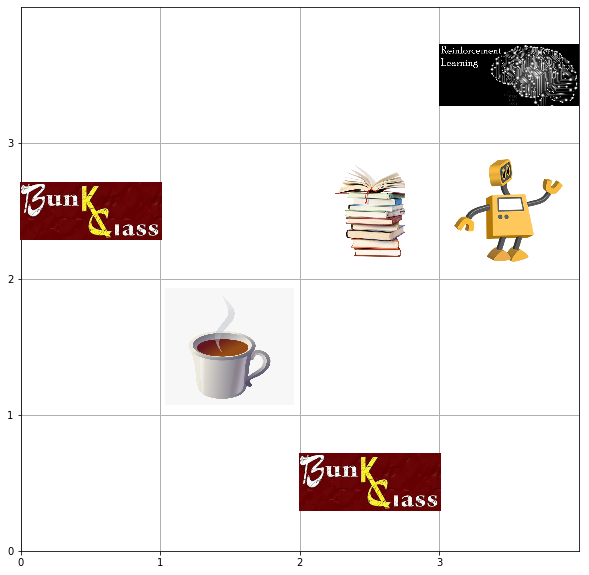

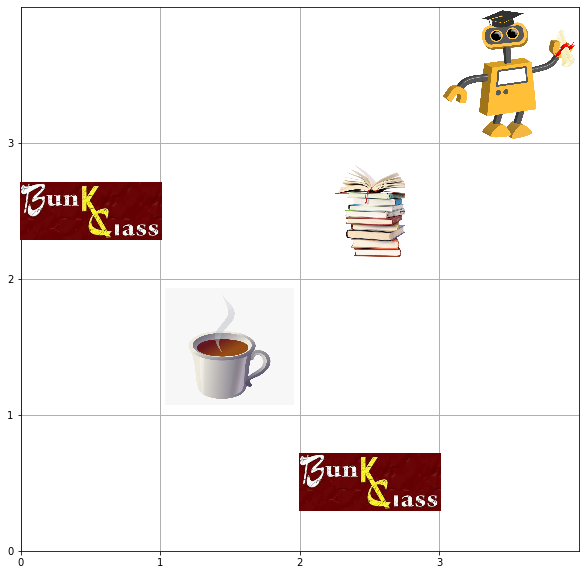

In [856]:
print("Model: ",ttm.logs['model'],"Environment type: ",ttm.logs['env_type'])
ttm.testModels(ttm.logs['qtable'],ttm.logs['env_type'],ttm.logs['env'])